## An architecture's energy and latency breakdown

In this demo, we dive deeper into the internal components of ZigZag's cost model by showing key aspects in the energy and latency calculation of a layer. Furthermore, it shows the distribution of energy and latency across the different layers of the entire network. Here, we show the convolutional ones of AlexNet on a list of saved CMEs.

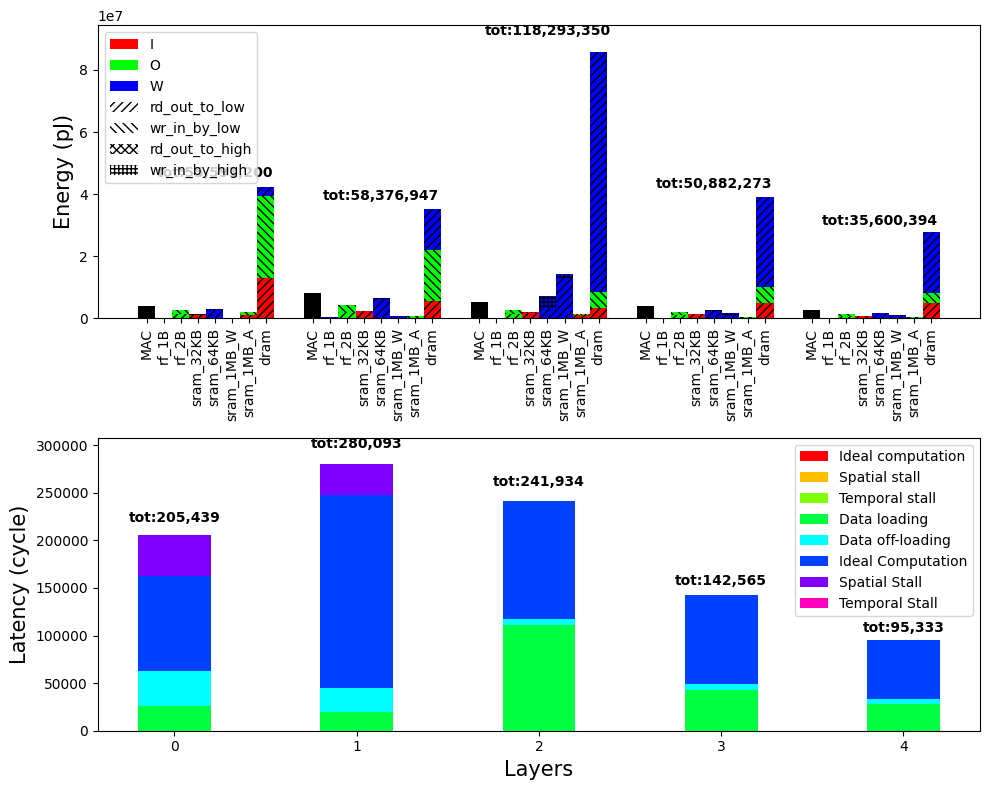

In [2]:
import pickle
from zigzag.visualization.results.plot_cme import bar_plot_cost_model_evaluations_breakdown

# Load in the pickled list of CMEs
with open("outputs/list_of_cmes.pickle", 'rb') as fp:
    breakdown_cmes = pickle.load(fp)

# Plot all the layers and save to 'plot_all.png'
bar_plot_cost_model_evaluations_breakdown(breakdown_cmes[:5], save_path="plot_breakdown.png")


As mentioned, this plot shows the different layers of AlexNet. It has two core components: the top one showing the energy breakdown, and the bottom one latency breakdown. 

### Energy breakdown

Different layer shapes have different activation sizes (I/O) and parameter sizes (W), which cause a varying number of memory accesses, depending on the layout of the memory hierarchy for each of these operands and the achievable reuse for each operand within each memory.

### Latency breakdown

Different aspects impact the latency. The spatial under-utilization of the array leads to "spatial stalls", where as insufficient memory bandwidth can lead to temporal stalls.